<a href="https://colab.research.google.com/github/sridata24/Snowflake-Labs/blob/main/OxML_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OXML 2025: Part I of practical session (generative model) -- Diffusion Model

## Introduction of Diffussion models
What is diffussion model? Why it success?
* The key to diffusion models’ success lies in their **iterative generation process**.
* Generation starts from **random noise** and is gradually refined over many steps to produce the final image.
* At each step, the model **predicts how to move from the current input toward a fully denoised version**.
* Since only **small changes** are made at each step:

  * Errors in early predictions (when the final output is hard to infer)
  * Can be **corrected in later updates**.


<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>


**Diffussion Model**
* Diffusion models are trained to denoise images
* Eventually, they generate images by iteratively denoising pure noise

They are built on two simple components:
* a function that degrades images by adding Gaussian noise
* a simple image restoration model for removing this noise.

## Diffusers
A package we used today:
* gather recent diffusion models from independent repositories in a single and long-term maintained project that is built by and for the community,
* reproduce high impact machine learning systems such as DALLE and Imagen in a manner that is accessible for the public, and
* create an easy to use API that enables one to train their own models or re-use checkpoints from other repositories for inference.

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

!pip install torch torchvision matplotlib
!pip install git+https://github.com/huggingface/diffusers.git#egg=diffusers[training]
!pip install accelerate
!pip install datasets
!pip install diffusers==0.11.1
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Inference of Diffussion Model

As a quick recap, diffusion models are machine learning systems that are trained to **denoise** random gaussian noise step by step, to get to a sample of interest, such as an *image*.

The underlying model, often a neural network, is trained to predict a way to slightly denoise the image in each step. After certain number of steps, a sample is obtained.

The process is illustrated by the following design:
![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusion-process.png)

The architecture of the neural network, referred to as **model**, commonly follows the UNet architecture as proposed in [this paper](https://arxiv.org/abs/1505.04597) and improved upon in the Pixel++ paper.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

No worries if you don't understand everything. Some of the highlights of the architecture are:
* this model predicts images of the same size as the input
* the model makes the input image go through several blocks of ResNet layers which halves the image size by 2
* then through the same number of blocks that upsample it again.
* skip connections link features on the downsample path to corresponding layers in the upsample path.


### A toy example

Using device: cuda
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([9, 3, 4, 9, 2, 2, 2, 2])


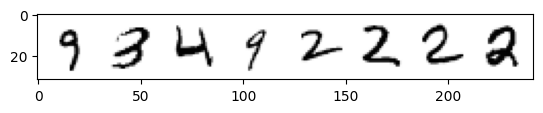

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
# from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

**The Corruption Process**
Pretend you haven’t read any diffusion model papers, but you know the process involves adding noise. How would you do it?

We probably want an easy way to control the amount of corruption. So what if we take in a parameter for the amount of noise to add, and then we do:

```
noise = torch.rand_like(x)
noisy_x = (1-amount)*x + amount*noise
```

If amount = 0, we get back the input without any changes. If amount gets up to 1, we get back noise with no trace of the input x. By mixing the input with noise this way, we keep the output in the same range (0 to 1).

We can implement this fairly easily (just watch the shapes so you don’t get burnt by broadcasting rules):

In [ ]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

Let's see how it works:

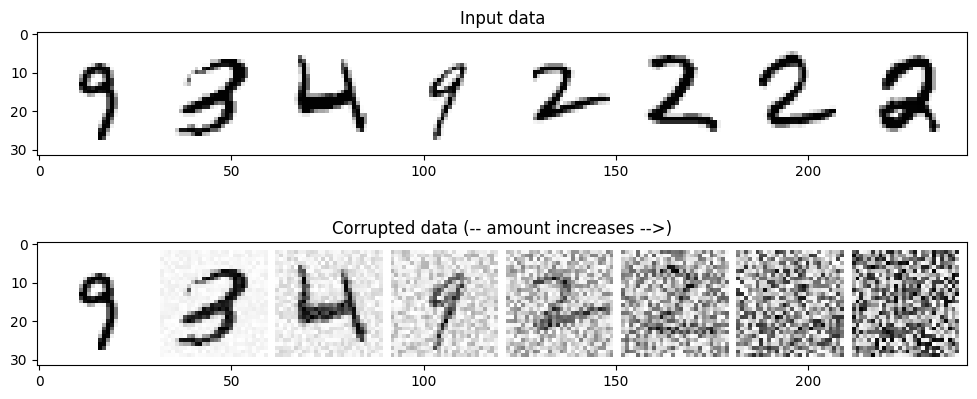

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

The diffusion process consists in taking random noise of the size of the desired output and pass it through the model several times. The process ends after a given number of steps, and the output image should represent a sample according to the training data distribution of the model, for instance an image of a butterfly.

During training we show many samples of a given distribution, such as images of butterfly. After training, the model will be able to process random noise to generate similar butterfly images.

Without going in too much detail, the model is usually not trained to directly predict a slightly less noisy image, but rather to predict the "noise residual" which is the difference between a less noisy image and the input image (for a diffusion model called "DDPM") or, similarly, the gradient between the two time steps (like the diffusion model called "Score VE").

To do the denoising process, a specific noise scheduling algorithm is thus necessary and "wrap" the model to define how many diffusion steps are needed for inference as well as how to *compute* a less noisy image from the model's output. Here is where the different **schedulers** of the diffusers library come into play.

Finally, a **pipeline** groups together a **model** and a **scheduler** and make it easy for an end-user to run a full denoising loop process. We'll start with the pipelines and dive deeper into its implementation before taking a closer look at models and schedulers.

### Pipeline
Let's begin by importing a pipeline. We'll use the `google/ddpm-celebahq-256` model, built in collaboration by Google and U.C.Berkeley. It's a model following the [Denoising Diffusion Probabilistic Models (DDPM) algorithm](https://arxiv.org/abs/2006.11239) trained on a dataset of celebrities images.

We can import the `DDPMPipeline`, which will allow you to do inference with a couple of lines of code:

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

We can see inside the pipeline a scheduler and a UNet model. Let's have a closer look at them and what this pipeline just did behind the scenes.

In [ ]:
images = image_pipe().images

In [ ]:
images[0]

### Model


In [ ]:
image_pipe.unet

Or you can define a model seperately:

In [ ]:
from diffusers import UNet2DModel

repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)

The configuration of the model can be accessed via the `config` attribute and shows all the necessary parameters to define the model architecture (and only those).

In [ ]:
model.config

As you can see, the model config is a frozen dictionary. This is to enforce that the configuration will **only** be used to define the model architecture at instantiation time and not for any attributes that can be changed during inference.

A couple of important config parameters are:
- `sample_size`: defines the `height` and `width` dimension of the input sample.
- `in_channels`: defines the number of input channels of the input sample.
- `down_block_types` and `up_block_types`: define the type of down- and upsampling blocks that are used to create the UNet architecture as was seen in the figure at the beginning of this notebook.
- `block_out_channels`: defines the number of output channels of the downsampling blocks, also used in reversed order for the number of input channels of the upsampling blocks.
- `layers_per_block`: defines how many ResNet blocks are present in each UNet block.

Knowing how a UNet config looks like, you can quickly try to instantiate the exact same model architecture with random weights. To do so, let's pass the config as an unpacked dict to the `UNet2DModel` class.


Let's now see how can we use the model for inference.

1. you need a random gaussian sample in the shape of an image (`batch_size` $\times$ `in_channels` $\times$ `sample_size` $\times$ `sample_size`).
2. We have a `batch` axis because a model can receive multiple random noises, a `channel` axis because each one consists of multiple channels (such as red-green-blue), and finally `sample_size` corresponds to the height and width.

In [ ]:
import torch

torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape


You can pass the noisy sample alongside a `timestep` through the model. The timestep is important to cue the model with "how noisy" the input image is (more noisy in the beginning of the process, less noisy at the end), so the model knows if it's closer to the start or the end of the diffusion process.

As explained in the introduction, the model predicts either the slightly less noisy image, the difference between the slightly less noisy image and the input image or even something else. It is important to carefully read through the [model card](https://huggingface.co/google/ddpm-church-256) to know what the model has been trained on. In this case, the model predicts the noise residual (difference between the slightly less noisy image and the input image).

In [ ]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

The predicted noisy_residual has the exact same shape as the input and we use it to compute a slightly less noised image.

In [ ]:
noisy_residual.shape

### Scheduler
**Schedulers** define the noise schedule which is used to add noise to the model during training, and also define the algorithm to *compute* the slightly less noisy sample given the model output (here `noisy_residual`). Here we focuse only on how to use *scheduler* classes for inference.

❗ It is important to stress here that while *models* have trainable weights, *schedulers* are usually *parameter-free* (in the sense they have no trainable weights) and simply define the algorithm to compute the slightly less noisy sample. Schedulers thus don't inherit from `torch.nn.Module`, but like models they are instantiated by a configuration.

To download a scheduler config from the Hub, you can make use of the `from_config()` method to load a configuration and instantiate a scheduler.

Let's take `DDPMScheduler` as an example, the denoising algorithm proposed in the [DDPM Paper](https://arxiv.org/abs/2006.11239).

In [ ]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(repo_id)

Here are the most important ones in the config:
- `num_train_timesteps` defines the length of the denoising process, e.g. how many timesteps are need to process random gaussian noise to a data sample.
- `beta_schedule` define the type of noise schedule that shall be used for inference and training
- `beta_start` and `beta_end` define the smallest noise value and highest noise value of the schedule.


All schedulers provide one or multiple `step()` methods that can be used to compute the slightly less noisy image. The `step()` method may vary from one scheduler to another, but normally expects at least the model output, the `timestep` and the current `noisy_sample`.

Note that the `step()` method is somewhat of a black box function that "just works". If you are keen to better understand how exactly the previous noisy sample is computed as defined in the original paper of the scheduler, you should take a look at the actual code, *e.g.* [click here](https://github.com/huggingface/diffusers/blob/936cd08488260a9df3548d66628b83bc7f26bd9e/src/diffusers/schedulers/scheduling_ddpm.py#L130) for DDPM, which contains comments and references to the original paper.

```
    def step(
        self,
        model_output: Union[torch.FloatTensor, np.ndarray],
        timestep: int,
        sample: Union[torch.FloatTensor, np.ndarray],
        predict_epsilon=True,
    ):
        t = timestep
        # 1. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[t - 1] if t > 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev

        # 2. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
        if predict_epsilon:
            pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
        else:
            pred_original_sample = model_output

        # 3. Clip "predicted x_0"
        if self.config.clip_sample:
            pred_original_sample = self.clip(pred_original_sample, -1, 1)

        # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * self.betas[t]) / beta_prod_t
        current_sample_coeff = self.alphas[t] ** (0.5) * beta_prod_t_prev / beta_prod_t

        # 5. Compute predicted previous sample µ_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample

        return {"prev_sample": pred_prev_sample}
```
Let's give it a try using the model output from the previous section.

In [ ]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

You can see that the computed sample has the exact same shape as the model input, meaning that you are ready to pass it to the model again in a next step.

Let's see what happen in the denoising loop:

In [ ]:
import PIL.Image
import numpy as np
import tqdm

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

model.to("cuda")
noisy_sample = noisy_sample.to("cuda")


sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

Now you should have gotten a good first understanding of the inference process. The important things to remember are:
1. schedulers are *parameter-free* (no trainable weights)
2. schedulers define the algorithm computing the slightly less noisy sample during inference

They are many schedulers already added to `diffusers` and diffusers will be adding even more in the future. It's important that you read the model cards to understand which model checkpoints can be used with which schedulers.
You can find all available schedulers [here](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers).

## Training of Diffussion Model

Let's recall the process:

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Don't worry too much about the math if you're not familiar with it, the import part to remember is that our model corresponds to the arrow $p_{\theta}(x_{t-1}|x_{t})$ (which is a fancy way of saying: predict a slightly less noisy image).



The interesting part is that it's really easy to add some noise to an image, so the training can happen in a semi-supervised fashion as follows:
1. Take an image from the training set.
2. Apply to it some random noise $t$ times (this will give the $x_{t-1}$ and the $x_{t}$ in the figure above).
3. Give this noisy image to the model along with the value of $t$.
4. Compute a loss from the output of the model and the noised image $x_{t-1}$.

Then we can apply gradient descent and repeat this process multiple times.

### A toy example

First we define a simple UNet:

In [ ]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

In [ ]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

In [ ]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

In [ ]:
# @markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

**Sampling**
If our predictions at high noise levels aren’t very good, how do we generate images?

Well, what if we start from random noise, look at the model predictions but then only move a small amount towards that prediction - say, 20% of the way there. Now we have a very noisy image in which there is perhaps a hint of structure, which we can feed into the model to get a new prediction. The hope is that this new prediction is slightly better than the first one (since our starting point is slightly less noisy) and so we can take another small step with this new, better prediction.

Repeat a few times and (if all goes well) we get an image out! Here is that process illustrated over just 5 steps, visualizing the model input (left) and the predicted denoised images (right) at each stage. Note that even though the model predicts the denoised image even at step 1, we only move x part of the way there. Over a few steps the structures appear and are refined, until we get our final outputs.

### Train a diffusion model using Diffusers
Code Example:
- Base Model: UNet2DModel
- Dataset: a subset of the Smithsonian Butterflies dataset.

#### Config

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-butterflies-128'  # the model namy locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

#### Data, Dataset

In [ ]:
from datasets import load_dataset

config.dataset = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset, split="train")

# Feel free to try other datasets from https://hf.co/huggan/ too!
# Here's is a dataset of flower photos:
# config.dataset = "huggan/flowers-102-categories"
# dataset = load_dataset(config.dataset, split="train")

# Or just load images from a local folder!
# config.dataset = "imagefolder"
# dataset = load_dataset(config.dataset, data_dir="path/to/folder")
dataset

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from PIL import Image



def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

The images in the dataset are all different, so we need to preprocess them first:
* `Resize` makes the images conform to a square resolution of `config.image_size`
* `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
* `Normalize` is important to rescale the pixel values into a `[-1, 1]` range (which our model will expect).

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

🤗 Datasets offer a handy `set_transform()` method to apply the image transformations on the fly during training:

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

**Model**

In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

Great!

Note that our model takes in the (noisy) image and also the current time-step (as we saw before in the training overview). That time-step information is converted for the model using a sinusoidal positional embedding, similar to what Transformer models often do.

Now that we have our model, we just need an object to *add noise to an image*. This is done by the **schedulers** in the `diffusers` library.

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, tensor_format="pt")

Let's see how this noise scheduler works: it takes a batch of images from the trainng set, a batch of random noise of the same shape and the timesteps for each image (which correspond to the number of times we want to apply noise to each image):

In [ ]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

In [ ]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In the DDPM algorithm, the training objective of the model is then to be able to predict the noise we used in `noise_scheduler.add_noise`, so the loss at this step would be:

In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps)["sample"]
loss = F.mse_loss(noise_pred, noise)

#### Setting up training

We have all we need to be able to train our model! Let's use a standard AdamW optimizer:

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

 And a cosine learning rate schedule:

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

To evaluate our model, we use the `DDPMPipeline` which is an easy way to perform end-to-end inference (see this notebook [TODO link] for more detail). We will use this pipeline to generate a batch of sample images and save it as a grid to the disk.

In [ ]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    )["sample"]

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

With this in end, we can group all together and write our training function. This just wraps the training step we saw in the previous section in a loop, using Accelerate for easy TensorBoard logging, gradient accumulation, mixed precision training and multi-GPUs or TPU training.

In [ ]:
from accelerate import Accelerator
from diffusers.hub_utils import init_git_repo, push_to_hub

from tqdm.auto import tqdm
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo = init_git_repo(config, at_init=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps)["sample"]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    push_to_hub(config, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

#### Let's train!

Let's launch the training (including multi-GPU training) from the notebook using Accelerate's `notebook_launcher` function:

In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Let's have a look at the final image grid produced by the trained diffusion model:

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

Not bad! There's room for improvement of course, so feel free to play with the hyperparameters, model definition and image augmentations 🤗
